In [1]:
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch import Tensor
import functools
import os
import numpy as np

import warnings
import glob


import io
from joblib import delayed 

from cacher import root, file_cached, mem_cached, clear_cache

import pymorphy2

from corus import load_lenta2
from navec import Navec
from razdel import tokenize, sentenize
from nerus import load_nerus

from utils import ProgressParallel
from joblib import delayed

from utils import download_file

from slovnet.model.emb import NavecEmbedding

# from torchmetrics.functional.classification import binary_accuracy

import random
import string


from pymorphy2.tagset import OpencorporaTag
from params import NO_PUNCT, build_params
morph = pymorphy2.MorphAnalyzer()

# https://pymorphy2.readthedocs.io/en/stable/user/grammemes.html
# http://opencorpora.org/dict.php?act=gram
# https://github.com/pymorphy2/pymorphy2/blob/92d546f042ff14601376d3646242908d5ab786c1/pymorphy2/tagset.py#L130
feature_tags_array = [
    OpencorporaTag.PARTS_OF_SPEECH, # часть речи
    OpencorporaTag.GENDERS, # род
    OpencorporaTag.NUMBERS, # число
    OpencorporaTag.CASES, # падеж
    OpencorporaTag.ASPECTS, # соверш / несоверш
    OpencorporaTag.TRANSITIVITY, # перех / непереходный
    OpencorporaTag.PERSONS, # лицо
    OpencorporaTag.TENSES, # время
    OpencorporaTag.MOODS, # наклонение
    OpencorporaTag.VOICES, # залог
    #INVOLVEMENT
    ['Prnt'], # вводные слова
    ['Apro'], # местоимение
    ['NUMB'], # число вида 1234
    ['LATIN'], # текст на английском
    ['UNKN'], # неизвестный токен
    ['PUNCT_DASH', 'PUNCT_DOT', 'PUNCT_COMMA', 'PUNCT_QUOTE',
     'PUNCT_LEFT_PARENTHESIS', 'PUNCT_RIGHT_PARENTHESIS' ], # "()
    ['CAPITALIZED'], # начинается с заглавной буквы
    ['Fixd', 'Abbr'] # неизменяемое, сокращение
]

CUT_NAVEC_TAGS_ARRAY = [
    #'NOUN', #'ADJF'
]

params = build_params({
    "VARIANTS_CNT": 1,
    "TARGET_CLASSES_COUNT": 3,
    "INPUT_WORDS_CNT": 16,
    "feature_tags_array": feature_tags_array,
    "PUNCTUATION_TARGET": {
        "$empty": NO_PUNCT,
        ",": 1,
        ".": 2,
        "!": 2,
        "?": 2,
    },
    "USE_NAVEC": True,
    'CUT_NAVEC_TAGS_SET': set(CUT_NAVEC_TAGS_ARRAY),
    'INFECTED_TEXT_PROB': 0.1,
})
torch.cuda.is_available(), torch.rand(10).to('cuda:0')




(True,
 tensor([0.0187, 0.6216, 0.4848, 0.6692, 0.3142, 0.5129, 0.3501, 0.9481, 0.1627,
         0.9963], device='cuda:0'))

In [18]:
from mosestokenizer import MosesTokenizer, MosesSentenceSplitter, MosesPunctuationNormalizer
punctuation_normalizer = MosesPunctuationNormalizer('ru')

punctuation_normalizer('сказал т.е. объяснил>>')
sentence_splitter = MosesSentenceSplitter('')
sentence_splitter(["В след за операми «Идоменей» В.А. Моцарта – Р. Штрауса "])

['В след за операми «Идоменей» В.А. Моцарта – Р.', 'Штрауса']

In [2]:
import dataset_builder 
import importlib
importlib.reload(dataset_builder) 
dataset_builder.get_word_features('кошка', params).shape

torch.Size([354])

In [2]:
import dataset_builder 
import zipfile
import importlib
import gc
importlib.reload(dataset_builder) 
# input, output = create_dataset([
#     'Однако самые ранние свидетельства приручения кошек древними египтянами относились к 2000—1900 годам до нашей эры. А недавно было установлено, что в Древний Египет домашняя кошка попала, как и на Кипр, с территории Анатолии. В настоящее время кошка является одним из самых популярных домашних животных. ',
#     'В лесу родилась елочка, в лесу она росла.'])
# input.shape, output.shape

lenta_path = download_file("lenta-ru-news.csv.gz", 
    "https://github.com/yutkin/Lenta.Ru-News-Dataset/releases/download/v1.1/lenta-ru-news.csv.bz2")
nerus_file = download_file("nerus_lenta.conllu.gz", "https://storage.yandexcloud.net/natasha-nerus/data/nerus_lenta.conllu.gz")

def get_lenta_records():
    return load_lenta2(lenta_path)

def read_lenta_records(records, cnt):
    res = []
    for record in records:
        res.append(record.text)
        if len(res) >= cnt: break
    return res

# https://www.kaggle.com/datasets/d0rj3228/russian-literature
writers_zip_path = "./dataset.zip"

def read_writers():
    res = []
    with zipfile.ZipFile(writers_zip_path, 'r') as writers_dir:
        for file in writers_dir.filelist:
            f = file.filename
            good_file = ('prose' in f or 'publicism' in f) and 'txt' in f and 'Tolstoy' in f
            if not good_file: continue
            with writers_dir.open(f) as file_open:
                res.append(file_open.read().decode())
    return res

def get_nerus_records():
    return load_nerus(nerus_file)

def read_nerus_records(records, cnt):
    res = []
    for record in records:
        for sent in record.sents:
            res.append(sent)        
            if len(res) >= cnt: return res
    return res
# res = read_writers()
# sum(map(len, res)),sum(map(len, read_lenta_records(10000)))


def concat_lists(lists):
    return [item for sublist in lists for item in sublist]

# @mem_cached("create_lenta_dataset")
# @file_cached("create_dataset")
def create_dataset(cnt, parts, params):
    if params['type'] == "lenta":
        records = get_lenta_records()
        method = read_lenta_records
    # elif params['type'] == "writers":
    #     texts = read_writers()
    elif params['type'] == "nerus":
        records = get_nerus_records()
        method = read_nerus_records 

    dataset_res = []
    for i in range(parts):
        gc.collect()
        print("part", i, "/", parts)
        texts = method(records, cnt // parts)
        rows = dataset_builder.create_dataset(texts, params)
        if len(dataset_res) == 0:
            dataset_res = list(rows)
        else:
            for i in range(len(dataset_res)):
                if isinstance(rows[i], list):
                    dataset_res[i] = concat_lists((rows[i], dataset_res[i], ))
                else:
                    dataset_res[i] = torch.cat((rows[i], dataset_res[i]))

    return {"input": dataset_res[0], 
            "output": dataset_res[1], 
            "texts_res": dataset_res[2], 
            "is_infected": dataset_res[3]}

params['type'] = 'lenta' #'nerus'
dataset = create_dataset(15000, 2, params) # 150_000 # 600_000
gc.collect()
input, output = dataset['input'], dataset['output']
input.shape, output.shape, len(dataset['texts_res']), dataset['is_infected'].shape, dataset['is_infected'].sum()



part 0 / 2


  0%|          | 0/7500 [00:00<?, ?it/s]

part 1 / 2


  0%|          | 0/7500 [00:00<?, ?it/s]

(torch.Size([488668, 16, 363]),
 torch.Size([488668, 3]),
 488668,
 torch.Size([488668]),
 tensor(48924))

In [3]:
def size_of_tensor(tensor):
    return str(round(tensor.nelement() * tensor.element_size() / 1024 / 1024 )) + " Mb"
def count_parameters(model):
    param_size = 0
    for param in model.parameters():
        param_size += param.nelement() * param.element_size()
    return param_size / 1024 ** 2
# cnt = 686492 # 400000
# input = dataset['input'] = dataset['input'][:cnt]
# output = dataset['output'] = dataset['output'][:cnt]
# dataset['texts_res'] = dataset['texts_res'][:cnt]
# dataset['is_infected'] = dataset['is_infected'][:cnt]
size_of_tensor(input), size_of_tensor(output), torch.sum(output, 0) / len(output)

('10827 Mb', '6 Mb', tensor([0.4109, 0.3526, 0.2365]))

In [4]:
from xformers.factory import xFormerEncoderBlock, xFormerEncoderConfig

N_words = params["INPUT_WORDS_CNT"]
# N_variants = params["VARIANTS_CNT"]
N_features = params["TOTAL_WORD_FEATURES_CNT"]

INTERNAL_EMBEDDING_SIZE = 64

encoder_config = {
    "dim_model": INTERNAL_EMBEDDING_SIZE, #N_variants * N_features,
    "residual_norm_style": "pre",  # Optional, pre/post
    "position_encoding_config": {
        "name": "sine",  #sine
        # "dim_model": VARIANTS_CNT * N_features,
    },
    "multi_head_config": {
        "num_heads": 4,
        "residual_dropout": 0.,
        "attention": {
            "name": "scaled_dot_product", #linformer scaled_dot_product fourier_mix, "linformer" scaled_dot_product,  # whatever attention mechanism
            "dropout": 0., # linformer
            "seq_len": N_words, # linformer, scaled_dot_product
            "to_seq_len": N_words, # scaled_dot_product
        },
    },
    "feedforward_config": {
        "name": "MLP",
        "dropout": 0.,
        "activation": "relu",
        "hidden_layer_multiplier": 1,
    },
}

A matching Triton is not available, some optimizations will not be enabled.
Error caught was: No module named 'triton'
Triton is not available, some optimizations will not be enabled.
This is just a warning: No module named 'triton'
Triton is not available, FusedMLP will not be enabled.
Either FairScale or torch distributed is not available, MixtureOfExperts will not be exposed. Please install them if you would like to use MoE


0.197 Mb of parameters
1 22.7
2 22.7
3 22.7
4 22.7
5 22.7
6 30.4
7 30.4
9 22.7
[0/400] [3.3 s]	 loss: 0.4769 loss_test: 0.2836  lr: 0.0010  
[1/400] [6.0 s]	 loss: 0.2952 loss_test: 0.2304  lr: 0.0010  
[2/400] [8.8 s]	 loss: 0.2585 loss_test: 0.2102  lr: 0.0010  
[3/400] [11.6 s]	 loss: 0.2379 loss_test: 0.1985  lr: 0.0010  
[4/400] [14.4 s]	 loss: 0.2236 loss_test: 0.1914  lr: 0.0010  
[5/400] [17.2 s]	 loss: 0.2132 loss_test: 0.1872  lr: 0.0010  
[6/400] [20.0 s]	 loss: 0.2053 loss_test: 0.1843  lr: 0.0010  
[7/400] [22.8 s]	 loss: 0.1988 loss_test: 0.1829  lr: 0.0010  
[8/400] [25.6 s]	 loss: 0.1935 loss_test: 0.1821  lr: 0.0010  
[9/400] [28.4 s]	 loss: 0.1891 loss_test: 0.1819  lr: 0.0010  
[10/400] [31.2 s]	 loss: 0.1851 loss_test: 0.1822  lr: 0.0010  
[11/400] [34.0 s]	 loss: 0.1817 loss_test: 0.1826  lr: 0.0010  
[12/400] [36.8 s]	 loss: 0.1784 loss_test: 0.1832  lr: 0.0010  
[13/400] [39.7 s]	 loss: 0.1754 loss_test: 0.1843  lr: 0.0010  
[14/400] [42.5 s]	 loss: 0.1727 loss_t

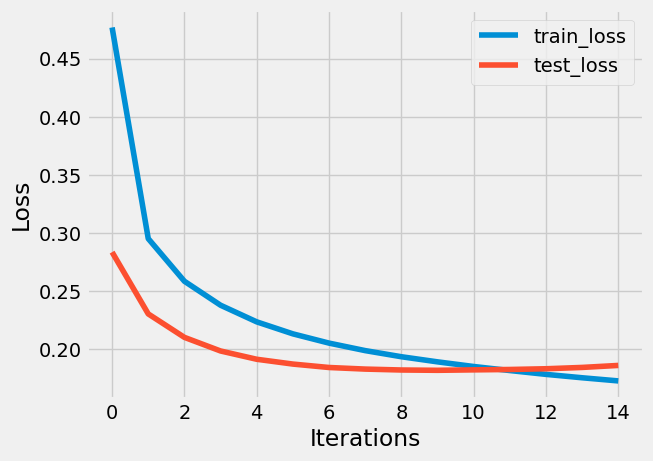

In [5]:
class Model(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        N_words = params['INPUT_WORDS_CNT']
        # N_variants = params['VARIANTS_CNT']
        N_features = params['TOTAL_WORD_FEATURES_CNT']

        # input is (N, N_words, N_features)
        # output is (N, N_words, )

        self.model = nn.Sequential(
            # nn.Flatten(2), 
            # (N, N_words, N_features + )
            # nn.TransformerEncoder(encoder_layer, num_layers=1),encoder = 
            nn.Linear(N_features, INTERNAL_EMBEDDING_SIZE),
            nn.BatchNorm1d(N_words),
            nn.ReLU(),
            
            xFormerEncoderBlock(xFormerEncoderConfig(**encoder_config)),
            # xFormerEncoderBlock(xFormerEncoderConfig(**encoder_config)),
            # xFormerEncoderBlock(xFormerEncoderConfig(**encoder_config)),
            # xFormerEncoderBlock(xFormerEncoderConfig(**encoder_config)),

            nn.Flatten(1), # (N, N_words* INTERNAL_EMBEDDING_SIZE)
            # nn.Tanh(),
            nn.Linear(N_words* INTERNAL_EMBEDDING_SIZE, params['TARGET_CLASSES_COUNT']),
            # nn.ReLU(),
            # nn.Linear(100, TARGET_CLASSES_COUNT),
            # nn.Tanh(),
            # nn.Tanhshrink(),
            # nn.Sigmoid(),
            # nn.ReLU(),
        )


    def forward(self, x):
        return self.model(x)

    # buffer_size = 0
    # for buffer in model.buffers():
    #     buffer_size += buffer.nelement() * buffer.element_size()
    # return (param_size + buffer_size) / 1024**2


aa = {}
def train_model():
    model = Model()
    print(round(count_parameters(model), 3), "Mb of parameters")
    import importlib
    import trainer_mod
    importlib.reload(trainer_mod)
    Trainer = trainer_mod.Trainer

    optimizer = torch.optim.Adam(model.parameters(), 
                            lr=1e-3)
                            # betas=(0.5, 0.999))

    trainer = Trainer(model=model, 
                    # enable_chunking=True,
                    # loss=nn.MSELoss(),
                    loss=nn.CrossEntropyLoss(),
                    optimizer=optimizer,
                    scheduler=None,
                    # scheduler=ReduceLROnPlateau(optimizer, factor=0.2, threshold=1e-5, patience=50),
                    additional_losses={
                        # "accurancy": lambda trainer: {"accurancy": 
                        #    float(torch.mean(torch.abs(trainer.model(trainer.x_test) - trainer.y_test)).detach())
                        # },
                    })

    infected_indices = torch.arange(input.shape[0])[dataset['is_infected']]
    trainer.set_data(input, output, train_test_split=0.9, not_test_indices=infected_indices)
    try:
        trainer.train(400, batch=2000, trial=None, log=True) # , chunk_size=680000,
    except KeyboardInterrupt:
        print("interrupted")
        # type, val, tb = sys.exc_info()
        # traceback.clear_frames(tb)
        pass
    
    trainer.plot_history(cutoff=0)
    return trainer
import os
# os.environ["CUDA_HOME"] = "/home/misha-sh/cuda"

trainer = train_model()
# run_proc(train_model)

In [ ]:
Positional embedding должен быть около знака препинания, а не около начала

In [6]:
import __main__

for i in ["_", "__", "___", "____", "_____", "trainer", "model", "optimizer", "Out"] + \
         ["_" + str(j) for j in range(100)]:
    for j in [locals(), globals(), __main__.__dict__]:
        try:
            del j[i]
        except: pass
        for f in range(100):
            try:
                del j["_oh"][f]
            except:
                pass
import sys
try:
    sys.last_traceback.tb_next = None
except: pass

import objgraph
for i in objgraph.by_type('Trainer'):
    i.model = None
    i.x = None
    i.y = None
    i.optimizer = None
    i.x_train = None
    i.y_train = None
    i.x_test = None
    i.y_test = None
    
import gc
aa.clear()
gc.collect()
torch.cuda.empty_cache() 
1/0


ZeroDivisionError: division by zero

<AxesSubplot: >

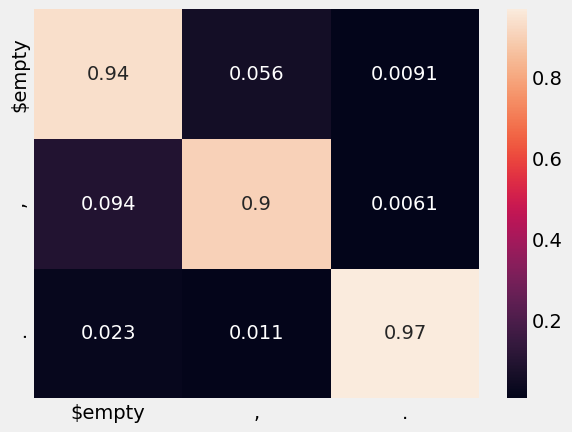

In [6]:
with torch.no_grad():
    trainer.model.eval()
    y_test_pred = trainer.model(trainer.x_test)
    _, y_pred_tags = torch.max(y_test_pred, dim = 1)
    y_pred = y_pred_tags.cpu().numpy()
    _, y_test_tags = torch.max(trainer.y_test, dim = 1)
    y_test = y_test_tags.cpu().numpy()
    
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_test, y_pred, normalize="true")).rename(
        columns=params['ID_TO_PUNCTUATION'], index=params['ID_TO_PUNCTUATION'])
sns.heatmap(confusion_matrix_df, annot=True)

In [15]:
morph.parse("Ивана Ивановича")

[Parse(word='ивана ивановича', tag=OpencorporaTag('NOUN,anim,masc,Patr sing,gent'), normal_form='ивана иванович', score=0.5, methods_stack=((FakeDictionary(), 'ивана ивановича', 26, 1), (KnownSuffixAnalyzer(min_word_length=4, score_multiplier=0.5), 'овича'))),
 Parse(word='ивана ивановича', tag=OpencorporaTag('NOUN,anim,masc,Patr sing,accs'), normal_form='ивана иванович', score=0.5, methods_stack=((FakeDictionary(), 'ивана ивановича', 26, 3), (KnownSuffixAnalyzer(min_word_length=4, score_multiplier=0.5), 'овича')))]

In [17]:
morph.parse("Собинбанке")

[Parse(word='собинбанке', tag=OpencorporaTag('NOUN,inan,femn sing,datv'), normal_form='собинбанка', score=0.2511013215859031, methods_stack=((DictionaryAnalyzer(), 'банке', 8, 2), (UnknownPrefixAnalyzer(score_multiplier=0.5), 'собин'))),
 Parse(word='собинбанке', tag=OpencorporaTag('NOUN,inan,femn sing,loct'), normal_form='собинбанка', score=0.2511013215859031, methods_stack=((DictionaryAnalyzer(), 'банке', 8, 6), (UnknownPrefixAnalyzer(score_multiplier=0.5), 'собин'))),
 Parse(word='собинбанке', tag=OpencorporaTag('NOUN,inan,masc sing,loct'), normal_form='собинбанк', score=0.2511013215859031, methods_stack=((DictionaryAnalyzer(), 'банке', 19, 5), (UnknownPrefixAnalyzer(score_multiplier=0.5), 'собин'))),
 Parse(word='собинбанке', tag=OpencorporaTag('NOUN,inan,masc,Orgn sing,loct'), normal_form='собинбанк', score=0.24669603524229075, methods_stack=((FakeDictionary(), 'собинбанке', 105, 5), (KnownSuffixAnalyzer(min_word_length=4, score_multiplier=0.5), 'банке')))]

In [12]:
import shap
import scipy as sp
# https://shap.readthedocs.io/en/latest/example_notebooks/text_examples/sentiment_analysis/Using%20custom%20functions%20and%20tokenizers.html

importlib.reload(dataset_builder)
trainer.model.eval()

import functools
@functools.lru_cache
def cached_word_features(tokens):
    return dataset_builder.get_word_features(tokens, params)

def inference(tokens_list):
    res = []
    features = torch.stack([
        torch.stack([cached_word_features(token) for token in tokens])
        for tokens in tokens_list])
    with torch.no_grad():
        model_pred = trainer.model(features.to(trainer.device))
        # _, val  = torch.max(model_pred, dim = 1)
        # res.append(val[0].item())
        outputs = model_pred.cpu().numpy()
        scores = (np.exp(outputs).T / np.exp(outputs).sum(-1)).T
        val = sp.special.logit(scores)
    return val
    # trainer.model

masker = shap.maskers.Text(dataset_builder.build_tokens, mask_token="UNDEF", collapse_mask_token=False, output_type="token_ids")

explainer = shap.Explainer(inference, masker, max_evals=100, output_names=["empty", ',', '.'])
# explainer = shap.explainers.Permutation(trainer.model, max_evals=3541)

for i in range(300, 350):
    text = dataset['texts_res'][trainer.test_indices[i]]
    text_input = text.copy()
    del text_input[params['INPUT_WORDS_CNT_LEFT']]

    model_res = inference([text_input])[0]
    if np.argmax(model_res) == np.argmax(dataset['output'][trainer.test_indices[i]]): continue
    # if np.argmax(model_res) != 2: continue

    text = " ".join(text)
    text_input = " ".join(text_input)
    print("TARGET:", text)
    print("INPUT:", text_input)
    print("OUTPUT:", model_res)
    # print("OUTPUT:", params["ID_TO_PUNCTUATION"][model_res])
    shap_values = explainer([text_input])
    shap.plots.text(shap_values)
    print("=" * 100)
    print("=" * 100)

TARGET: производству оружия массового поражения в Ираке и Иране  #,#  США в то же время упорно игнорируют существование
INPUT: производству оружия массового поражения в Ираке и Иране США в то же время упорно игнорируют существование
OUTPUT: [ 2.499456  -3.8319128 -2.849875 ]


TARGET: главный конструктор " одного оборонного конструкторского бюро "  #.#  Теперь связать обыск в Собинбанке со скандалом вокруг
INPUT: главный конструктор " одного оборонного конструкторского бюро " Теперь связать обыск в Собинбанке со скандалом вокруг
OUTPUT: [ 0.5089782 -5.378992  -0.528607 ]


TARGET: люди в основном выражают поддержку Путину как кандидату  #$empty#  в президенты и предлагают свою помощь в организации
INPUT: люди в основном выражают поддержку Путину как кандидату в президенты и предлагают свою помощь в организации
OUTPUT: [ -0.39196205   0.39188614 -10.911482  ]


TARGET: каждой лошадиной силы для автобусов - 12 рублей  #$empty#  с каждой лошадиной силы для грузовых автомобилей -
INPUT: каждой лошадиной силы для автобусов - 12 рублей с каждой лошадиной силы для грузовых автомобилей -
OUTPUT: [-3.5169666  3.490039  -7.1764913]


TARGET: грузовых автомобилей - от 8 до 26 рублей  #$empty#  с каждой лошадиной силы По словам Жарова повышение
INPUT: грузовых автомобилей - от 8 до 26 рублей с каждой лошадиной силы По словам Жарова повышение
OUTPUT: [-1.5594094  1.5453902 -6.2018304]


TARGET: размерах ( свыше пяти килограммов ) оружия боеприпасов  #,#  взрывчатых веществ Однако даже при наличии этих данных
INPUT: размерах ( свыше пяти килограммов ) оружия боеприпасов взрывчатых веществ Однако даже при наличии этих данных
OUTPUT: [ 1.1758775 -1.179382  -7.3677125]


TARGET: это было единственно верное решение " Таким образом  #$empty#  нам удалось избежать раскола и сделать шаг к
INPUT: это было единственно верное решение " Таким образом нам удалось избежать раскола и сделать шаг к
OUTPUT: [ -0.53021985   0.53011674 -10.635421  ]


TARGET: ( exit poll ) среди посетивших избирательные участки  #,#  и публиковать результаты опроса в Интернете В юридической
INPUT: ( exit poll ) среди посетивших избирательные участки и публиковать результаты опроса в Интернете В юридической
OUTPUT: [  0.23390526  -0.23405296 -10.218619  ]


In [19]:
text = 'PAD ' * 8 + 'Мама пришла , кот съел еду'+ ' PAD' * 7
text_input = text.split()
del text_input[params['INPUT_WORDS_CNT_LEFT']]

model_res = inference([text_input])[0]

text = " ".join(text)
text_input = " ".join(text_input)
print("TARGET:", text)
print("INPUT", text_input)
print("OUTPUT:", model_res)
# print("OUTPUT:", params["ID_TO_PUNCTUATION"][model_res])
shap_values = explainer([text_input])
shap.plots.text(shap_values)

TARGET: P A D   P A D   P A D   P A D   P A D   P A D   P A D   P A D   М а м а   п р и ш л а   ,   к о т   с ъ е л   е д у   P A D   P A D   P A D   P A D   P A D   P A D   P A D
INPUT PAD PAD PAD PAD PAD PAD PAD PAD Мама пришла кот съел еду PAD PAD PAD PAD PAD PAD PAD
OUTPUT: [  3.6143982  -3.615273  -10.711602 ]


In [ ]:
# chain[1] asdf
for elem in chain[1]:
    # if "trainer_mod.Trainer" in str(chain[1][elem]) and not isinstance(chain[1][elem], str)
    if chain[2] == chain[1][elem]:
        print(elem)

for elem in chain[2]:
    if "trainer_mod.Trainer" in str(chain[2][elem]) and not isinstance(chain[2][elem], str)
    # if chain[3] == chain[2][elem]:
        print(elem)

import torch.nn as nn
import torch
def ttest():
    model = nn.Linear(100 * 100, 1).to("cuda:0")
    try:
        for i in range(1000000000):
            pass
    except KeyboardInterrupt:
        print("wer")
        pass
    a = torch.rand(100).to('cuda:0')
    return model
model = ttest()

_oh


In [ ]:
inp = nn.Flatten(2)(input[:11])

config = xFormerEncoderConfig(**encoder_config)

encoder = xFormerEncoderBlock(config)

#  Test out with dummy inputs
x = (torch.rand((10, N_words, N_variants * N_features))).abs().to(torch.float32)
y = encoder(x) # (x, x, x)
print(x.shape, y.shape)

# a = nn.TransformerEncoderLayer(d_model=N_variants *N_features,
#                                nhead=4, dim_feedforward=10, batch_first=True)
# inp.shape, a(inp).shape, count_parameters(a)

In [ ]:
aa

{}

In [ ]:
%reset_selective trainer

In [ ]:

objgraph.find_backref_chain(objgraph.by_type('Trainer')[0], objgraph.is_proper_module)[-2]

SyntaxError: cannot delete function call (3434817761.py, line 2)

In [13]:
# import objgraph
# objgraph.show_backrefs(objgraph.by_type('Trainer'), 10)

In [ ]:
from xformers.factory import xFormerEncoderBlock, xFormerEncoderConfig
N_words = INPUT_WORDS_CNT
N_variants = VARIANTS_CNT
N_features = FEATURES_CNT

INTERNAL_EMBEDDING_SIZE = 4

encoder_config = {
    "dim_model": INTERNAL_EMBEDDING_SIZE, #N_variants * N_features,
    "residual_norm_style": "pre",  # Optional, pre/post
    "position_encoding_config": {
        "name": "sine",  # whatever position encodinhg makes sense
        # "dim_model": VARIANTS_CNT * N_features,
    },
    "multi_head_config": {
        "num_heads": 4,
        "residual_dropout": 0,
        "attention": {
            "name": "scaled_dot_product", #m fourier_mix, "linformer" scaled_dot_product,  # whatever attention mechanism
            "dropout": 0, # linformer
            "seq_len": N_words, # linformer, scaled_dot_product
            "to_seq_len": N_words, # scaled_dot_product
        },
    },
    "feedforward_config": {
        "name": "MLP",
        "dropout": 0,
        "activation": "relu",
        "hidden_layer_multiplier": 1,
    },
}
# print(INTERNAL_EMBEDDING_SIZE,
#         round(count_parameters(nn.Linear(N_variants * N_features, INTERNAL_EMBEDDING_SIZE)), 4),
#         round(count_parameters(xFormerEncoderBlock(xFormerEncoderConfig(**encoder_config))), 4), "x2 ",
#         round(count_parameters(nn.Linear(N_words* INTERNAL_EMBEDDING_SIZE, TARGET_CLASSES_COUNT)), 4),
#         "=",
#         round(count_parameters(Model()), 4))


In [ ]:
y_test, y_pred

(array([0, 2, 2, ..., 2, 0, 0]), array([0, 2, 2, ..., 1, 0, 0]))

In [ ]:
with torch.no_grad():
    model.eval()
    model.to

In [ ]:
y_test.shape, y_pred_list.shape

((167122, 3), (1, 167122))

In [ ]:
trainer.y_train

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 2.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 2., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0.])

In [ ]:
# scaler = GradScaler()

# for input, target in data:
#     with torch.autocast(device_type='cuda'):
#         output = model(input)
#         loss = loss_fn(output, target)
#     scaler.scale(loss).backward()
#     scaler.step(optimizer)
#     scaler.update()


In [ ]:


# import sys,functools, traceback
# def gpu_mem_restore(func):
#     "Reclaim GPU RAM if CUDA out of memory happened, or execution was interrupted"
#     @functools.wraps(func)
#     def wrapper(*args, **kwargs):
#         try:
#             return func(*args, **kwargs)
#         except:
#             type, val, tb = sys.exc_info()
#             traceback.clear_frames(tb)
#             raise type(val).with_traceback(tb) from None
#     return wrapper

# @gpu_mem_restore